### Proyecto de Análisis de Clusters para la Planificación de Estaciones de Metro

Este cuaderno realiza un análisis de agrupación (clustering) basado en coordenadas geográficas para la planificación de estaciones de metro. El objetivo es identificar puntos óptimos para ubicar las estaciones, priorizando ciertos tipos de lugares como universidades, aeropuertos, hospitales y centros comerciales, mientras se asigna menor prioridad a otros lugares como escuelas.

1. **Asignación de pesos**: Se asignan diferentes pesos a cada tipo de lugar según su importancia para la planificación.

   Estos pesos permiten ponderar las coordenadas en el análisis de agrupación, priorizando los lugares más importantes para que las estaciones se ubiquen lo más cerca posible de ellos.

2. **Análisis visual**: Se realizaron gráficos de densidad y de distribución de puntos por tipo de lugar, excluyendo algunos como las escuelas para facilitar la visualización. Además, se generaron gráficos de clusters donde se resaltan las áreas sombreadas correspondientes a cada agrupación.

3. **Clustering con K-Means**: Se utilizó el algoritmo de K-Means para crear grupos optimizados en función de las coordenadas geográficas y los pesos asignados. El objetivo es encontrar centros ideales para ubicar las estaciones de metro.

4. **Visualización de clusters**: Se graficaron los clusters y se representaron visualmente con colores más intensos para facilitar su comprensión, manteniendo la prioridad de los lugares como aeropuertos y universidades en la agrupación final.

---

**Hecho por:** Ronaldo Olivares

### Instalar paquetes

In [ ]:
!pip install folium geopandas shapely

In [ ]:
!pip install osmnx

### 1. Librerías y Configuración Inicial
En esta primera celda, importamos las librerías necesarias para trabajar con mapas (folium), datos geoespaciales (osmnx, geopandas y shapely), manipulación de datos (pandas), visualización de gráficos (matplotlib) y desactivamos algunos warnings deprecados para mantener el código limpio.

In [ ]:
# ========================================
# IMPORTACIÓN DE LIBRERÍAS
# ========================================
import folium  # Para visualización geográfica interactiva
import osmnx as ox  # OpenStreetMap para análisis de redes urbanas
import geopandas as gpd  # Geopandas para manejo de datos espaciales
from shapely.geometry import Point, Polygon  # Manejo de geometría (puntos y polígonos)
import pandas as pd  # Manejo de datos estructurados
from folium.plugins import MarkerCluster  # Agrupamiento de marcadores en mapas
from IPython.core.display import display, HTML  # Mostrar contenido HTML en Jupyter
from IPython.display import clear_output  # Limpiar la salida de la consola

# ========================================
# VISUALIZACIÓN Y ANÁLISIS DE DATOS
# ========================================
import matplotlib.pyplot as plt  # Para crear gráficos
import seaborn as sns  # Gráficos estadísticos avanzados con estilo
from sklearn.cluster import KMeans  # Algoritmo K-Means para clustering
import numpy as np  # Numpy para manejo de arrays y operaciones numéricas
from scipy.spatial import ConvexHull  # Para crear áreas convexas alrededor de los puntos

# ========================================
# MANEJO DE ERRORES Y ADVERTENCIAS
# ========================================
import warnings

# Ignorar advertencias de características obsoletas, importaciones, etc.
warnings.filterwarnings('ignore', category=DeprecationWarning)  # Características obsoletas
warnings.filterwarnings("ignore", category=ImportWarning)       # Problemas de importación
warnings.filterwarnings("ignore", category=UserWarning)         # Advertencias del usuario
warnings.filterwarnings("ignore", category=RuntimeWarning)      # Errores de ejecución
warnings.filterwarnings("ignore", category=FutureWarning)       # Advertencias de cambios futuros
warnings.filterwarnings("ignore", category=ResourceWarning)     # Advertencias de recursos
warnings.filterwarnings("ignore", message="find_spec() not found; falling back to find_module()")

### 2. Crear Polígono para el Área de Piura
En esta sección definimos un polígono que representa el área geográfica de Piura utilizando coordenadas geoespaciales. Creamos un mapa interactivo centrado en Piura y añadimos el polígono sombreado sobre la ciuda

In [ ]:
# Coordenadas aproximadas del polígono de Piura
coordenadas_poligono = [
    (-5.152237, -80.670147), (-5.173992, -80.676475),
    (-5.170739, -80.689234), (-5.193001, -80.685662),
    (-5.239433, -80.621118), (-5.206696, -80.561380),
    (-5.166350, -80.577430), (-5.145235, -80.676994),
    (-5.152237, -80.670147)
]

# Crear el polígono para el área de Piura
poligono_area = Polygon(coordenadas_poligono)

# Centro de Piura para centrar el mapa
piura_center = [-5.19449, -80.63282]

In [ ]:
# Crear el mapa con el polígono sombreado
mapa_piura_sombreado = folium.Map(location=piura_center, zoom_start=12)
folium.Polygon(
    locations=coordenadas_poligono,
    color='blue',
    fill=True,
    fill_opacity=0.5,
    tooltip='Área Sombreada'
).add_to(mapa_piura_sombreado)

In [ ]:
# Mostrar el mapa en un tamaño ajustado
display(HTML(f"""
    <div style="width: 600px; height: 400px; overflow: hidden; margin: auto;">
        {mapa_piura_sombreado._repr_html_()}
    </div>
"""))

### 3. Obtener Puntos de Interés desde OpenStreetMap

In [ ]:
# Definir los tipos de puntos de interés a obtener de OpenStreetMap
tags = {'amenity': ['school', 'university', 'hospital'],
        'aeroway': ['aerodrome'],
        'shop': ['mall']}

# Obtener las geometrías de los puntos de interés para Piura
puntos_importantes = ox.geometries_from_place('Piura, Peru', tags)

# Mostrar las primeras filas del DataFrame
puntos_importantes.head()

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

addr:district                  addr:full  \
element_type osmid                                                 
node         5497673354       Sechura           Nuevo Parachique   
             5497673355       Sechura        Ciudad Del Pescador   
             5497676343       Sechura  Avenida Guardia Civil S/n   
             5497676345       Sechura           Avenida Grau S/n   
             5497676347       Sechura       Calle Jose Olaya S/n   

                        addr:province      addr:subdistrict amenity ele  \
element_type osmid                                                        
node         5497673354       Sechura      Nuevo Parachique  school  11   
             5497673355       Sechura      Nuevo Parachique  school  11   
             5497676343       Sechura  La Bocana/parachique  school   2   
             5497676345       Sechura  La Bocana/parachique  school   2   
             5497676347       Sechura  La Bocana/parachique  school   2   

                        isced:level  \
element_type osmid                    
node         5497673354           1   
             5497673355           1   
             5497676343         1;2   
             5497676345           2   
             5497676347           1   

                                                                      name  \
element_type osmid                                                           
node         5497673354                    Institución Educativa No. 15318   
             5497673355                   Institución Educativa Cristo Rey   
             5497676343                      Institución Educativa Betania   
             5497676345                    Institución Educativa San Pedro   
             5497676347  Institución Educativa 14083 Maria V Rumiche Fi...   

                                    note      ref  ... pe:minsa:categoria  \
element_type osmid                                 ...                      
node         5497673354  Med_gps (local)  0616771  ...                NaN   
             5497673355     Med-gps (cp)  1606722  ...                NaN   
             5497676343  Med_gps (local)  1436237  ...                NaN   
             5497676345  Med_gps (local)  0674341  ...                NaN   
             5497676347  Med_gps (local)  0350215  ...                NaN   

                        pe:minsa:codigo contact:whatsapp grades preschool  \
element_type osmid                                                          
node         5497673354             NaN              NaN    NaN       NaN   
             5497673355             NaN              NaN    NaN       NaN   
             5497676343             NaN              NaN    NaN       NaN   
             5497676345             NaN              NaN    NaN       NaN   
             5497676347             NaN              NaN    NaN       NaN   

                        email  fax addr:place school type  
element_type osmid                                         
node         5497673354   NaN  NaN        NaN    NaN  NaN  
             5497673355   NaN  NaN        NaN    NaN  NaN  
             5497676343   NaN  NaN        NaN    NaN  NaN  
             5497676345   NaN  NaN        NaN    NaN  NaN  
             5497676347   NaN  NaN        NaN    NaN  NaN  

[5 rows x 69 columns]

### 4. Visualización por distritos

Aquí generamos un gráfico de barras que muestra los distritos con más de 60 puntos de interés. Esto nos permite visualizar los distritos con mayor densidad de infraestructuras importantes.

In [ ]:
# Contar puntos agrupados por distrito
conteo_distritos = puntos_importantes['addr:district'].value_counts()

# Mostrar el conteo de puntos por distrito
print(puntos_importantes.head())

                        addr:district                  addr:full  \
element_type osmid                                                 
node         5497673354       Sechura           Nuevo Parachique   
             5497673355       Sechura        Ciudad Del Pescador   
             5497676343       Sechura  Avenida Guardia Civil S/n   
             5497676345       Sechura           Avenida Grau S/n   
             5497676347       Sechura       Calle Jose Olaya S/n   

                        addr:province      addr:subdistrict amenity ele  \
element_type osmid                                                        
node         5497673354       Sechura      Nuevo Parachique  school  11   
             5497673355       Sechura      Nuevo Parachique  school  11   
             5497676343       Sechura  La Bocana/parachique  school   2   
             5497676345       Sechura  La Bocana/parachique  school   2   
             5497676347       Sechura  La Bocana/parachique  school   2  

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Visualizar las columnas
print(puntos_importantes.columns)

Index(['addr:district', 'addr:full', 'addr:province', 'addr:subdistrict',
       'amenity', 'ele', 'isced:level', 'name', 'note', 'ref', 'source',
       'geometry', 'addr:city', 'website', 'nodes', 'addr:street', 'name:es',
       'addr:neighbourhood', 'addr:state', 'denomination', 'religion',
       'wikimedia_commons', 'building', 'healthcare', 'addr:housenumber',
       'emergency', 'operator:type', 'operator', 'alt_name', 'operator:short',
       'operator:wikidata', 'barrier', 'wheelchair', 'fixme',
       'contact:facebook', 'healthcare:speciality', 'aerodrome:type',
       'aeroway', 'closest_town', 'iata', 'icao', 'name:en', 'wikidata',
       'wikipedia', 'phone', 'ref:category', 'addr:postcode', 'shop',
       'short_name', 'building:levels', 'opening_hours', 'toilets',
       'pe:minedu:codigo_local', 'ref:microred', 'ref:red', 'description',
       'internet_access', 'internet_access:ssid', 'old_name',
       'pe:minsa:categoria', 'pe:minsa:codigo', 'contact:whatsapp', 'gr

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

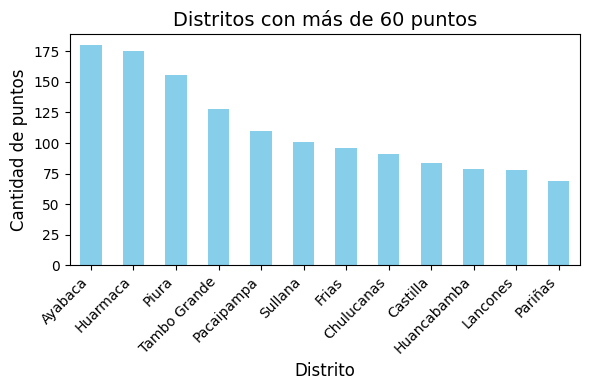

In [ ]:
# Filtrar distritos con más de 60 puntos
puntos_minimos = 60
distritos_mayor = conteo_distritos[conteo_distritos > puntos_minimos]

# Crear el gráfico de barras
plt.figure(figsize=(6, 4))
distritos_mayor.plot(kind='bar', color='skyblue')

# Añadir título y etiquetas
plt.title(f'Distritos con más de {puntos_minimos} puntos', fontsize=14)
plt.xlabel('Distrito', fontsize=12)
plt.ylabel('Cantidad de puntos', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Mostrar el gráfico
plt.tight_layout()
plt.show()


### 5. Filtrar datos

In [ ]:
def punto_en_poligono(lat, lon, poligono):
    n = len(poligono)
    dentro = False

    p1x, p1y = poligono[0]
    for i in range(n + 1):
        p2x, p2y = poligono[i % n]
        if lon > min(p1y, p2y):
            if lon <= max(p1y, p2y):
                if lat <= max(p1x, p2x):
                    if p1y != p2y:
                        xinters = (lon - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                    if p1x == p2x or lat <= xinters:
                        dentro = not dentro
        p1x, p1y = p2x, p2y

    return dentro

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Inicializar una lista para almacenar las coordenadas
coordenadas = []

# Iterar sobre los puntos de interés obtenidos de OpenStreetMap
for _, punto in puntos_importantes.iterrows():
    # Verificar si el punto es un polígono o un punto
    if isinstance(punto.geometry, Polygon):
        centroide = punto.geometry.centroid
        lat, lon = centroide.y, centroide.x
    elif isinstance(punto.geometry, Point):
        lat, lon = punto.geometry.y, punto.geometry.x
    else:
        continue

    # Guardar las coordenadas y el nombre del punto
    coordenadas.append([lat, lon, punto.get('name', 'Desconocido'), punto['amenity']])

In [ ]:
# Convertir la lista de coordenadas a un DataFrame
df_coordenadas = pd.DataFrame(coordenadas, columns=['Latitud', 'Longitud', 'Nombre', 'Tipo'])

# Filtrar los puntos dentro del polígono definido
df_coordenadas_filtradas = df_coordenadas[df_coordenadas.apply(
    lambda row: punto_en_poligono(row['Latitud'], row['Longitud'], coordenadas_poligono), axis=1
)]

# Mostrar el DataFrame filtrado
df_coordenadas_filtradas.head()

,Latitud,Longitud,Nombre,Tipo
31,-5.227581,-80.616733,Institución Educativa 15016 Sagrada Familia,school
32,-5.227223,-80.630952,Institución Educativa Agropecuario 07,school
33,-5.226781,-80.619238,Institución Educativa 14118 Marina Purizaca Be...,school
152,-5.227912,-80.611326,Institución Educativa Fe y Alegría 15,school
208,-5.229015,-80.631160,Innova Schools Chiclayito,school


### 6. Analisis de datos filtrados

In [ ]:
df_coordenadas_filtradas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 329 entries, 31 to 735
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Latitud   329 non-null    float64
 1   Longitud  329 non-null    float64
 2   Nombre    322 non-null    object 
 3   Tipo      308 non-null    object 
dtypes: float64(2), object(2)
memory usage: 12.9+ KB


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Localizar y actualizar el tipo del Aeropuerto Capitán FAP Guillermo Concha Iberico
df_coordenadas_filtradas.loc[df_coordenadas_filtradas['Nombre'] == 'Aeropuerto Capitán FAP Guillermo Concha Iberico', 'Tipo'] = 'aerodrome'

# Localizar los registros donde 'Nombre' es nulo o NaN
nombres_nulos = df_coordenadas_filtradas[df_coordenadas_filtradas['Nombre'].isna()]
print("Registros con 'Nombre' nulo o NaN:")
print(nombres_nulos)

# Eliminar los registros donde 'Nombre' es nulo o NaN
df_coordenadas_filtradas = df_coordenadas_filtradas.dropna(subset=['Nombre'])

# Localizar los registros donde 'Nombre' es nulo o NaN
nombres_nulos = df_coordenadas_filtradas[df_coordenadas_filtradas['Nombre'].isna()]
print("\n\nVerificar registros con 'Nombre' nulo o NaN:")
print(nombres_nulos)

Registros con 'Nombre' nulo o NaN:
      Latitud   Longitud Nombre    Tipo
209 -5.161111 -80.655443    NaN  school
210 -5.160414 -80.655279    NaN  school
613 -5.167326 -80.649809    NaN  school
669 -5.187553 -80.592533    NaN  school
689 -5.208138 -80.621579    NaN  school
732 -5.195770 -80.630371    NaN     NaN
734 -5.179322 -80.674048    NaN  school


Verificar registros con 'Nombre' nulo o NaN:
Empty DataFrame
Columns: [Latitud, Longitud, Nombre, Tipo]
Index: []


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Localizar los registros donde 'Tipo' es nulo o NaN
tipo_nulos = df_coordenadas_filtradas[df_coordenadas_filtradas['Tipo'].isna()]
print("\nRegistros con 'Tipo' nulo o NaN:")
print(tipo_nulos)

# Lista de nombres de los centros comerciales a conservar
centros_comerciales = ['Open Plaza Piura', 'Plaza del Sol', 'Centro Comercial Real Plaza', 'Plaza del Sol']

# Filtrar los registros donde el 'Nombre' sea uno de los centros comerciales
df_coordenadas_filtradas.loc[df_coordenadas_filtradas['Nombre'].isin(centros_comerciales), 'Tipo'] = 'mall'

# Eliminar los registros donde 'Tipo' es nulo o NaN y no están en la lista de centros comerciales
df_coordenadas_filtradas = df_coordenadas_filtradas.dropna(subset=['Tipo'])

# Localizar los registros donde 'Tipo' es nulo o NaN
tipo_nulos = df_coordenadas_filtradas[df_coordenadas_filtradas['Tipo'].isna()]

# Mostrar el DataFrame después de los cambios
print("\n\nVerificar registros con 'Tipo' nulo o NaN:")
print(tipo_nulos)


Registros con 'Tipo' nulo o NaN:
      Latitud   Longitud                           Nombre Tipo
588 -5.181944 -80.622288                 Open Plaza Piura  NaN
591 -5.192530 -80.639564                    Plaza del Sol  NaN
605 -5.185090 -80.641979      Centro Comercial Real Plaza  NaN
608 -5.188984 -80.632563            C.C. Mercado de Telas  NaN
614 -5.187227 -80.632365     Industria y servicios FALCON  NaN
615 -5.187121 -80.632304            La casa de las llaves  NaN
616 -5.186937 -80.632213                Vidriería JAYANGO  NaN
617 -5.186788 -80.632111             La casa del tornillo  NaN
618 -5.186615 -80.632061                  Pernos y afynes  NaN
623 -5.186500 -80.631944                       Cerrajería  NaN
624 -5.186439 -80.631910                        vidriería  NaN
625 -5.186148 -80.632612    Floristería Flores y Detalles  NaN
626 -5.186172 -80.632556             Venta de Lubricantes  NaN
627 -5.186668 -80.632849             Comercial Carhuapola  NaN
635 -5.195091 -80.630

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print("\nRegistros filtrados solo para universidades:")
print(df_coordenadas_filtradas[df_coordenadas_filtradas['Tipo'] == 'university'][['Latitud', 'Longitud', 'Nombre']])

# Eliminar las universidades especificadas
universidades_a_eliminar = [
    'Universidad Alas Peruanas',
    'Universidad San Pedro'
]
df_coordenadas_filtradas = df_coordenadas_filtradas[~df_coordenadas_filtradas['Nombre'].isin(universidades_a_eliminar)]

# Verificar que se eliminaron correctamente
print("\n\nRegistros después de eliminar las universidades especificadas:")
print(df_coordenadas_filtradas[df_coordenadas_filtradas['Tipo'] == 'university'][['Latitud', 'Longitud', 'Nombre']])


Registros filtrados solo para universidades:
      Latitud   Longitud                                             Nombre
587 -5.168160 -80.629348                 Universidad Privada Antenor Orrego
589 -5.177649 -80.617562                      Universidad Nacional de Piura
590 -5.172841 -80.639112                               Universidad de Piura
593 -5.174498 -80.663383                          Universidad Cesar Vallejo
696 -5.198382 -80.627132  Universidad Nacional de Piura - Escuela de Pos...
722 -5.182778 -80.640697           Universidad Técnológica del Perú - Piura
726 -5.187011 -80.583170                          Universidad Alas Peruanas
727 -5.184204 -80.581713                              Universidad San Pedro


Registros después de eliminar las universidades especificadas:
      Latitud   Longitud                                             Nombre
587 -5.168160 -80.629348                 Universidad Privada Antenor Orrego
589 -5.177649 -80.617562                      Univers

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Obtener el conteo por tipo nuevamente después de la eliminación
conteo_por_tipo = df_coordenadas_filtradas['Tipo'].value_counts()
print(conteo_por_tipo)

Tipo
school        286
hospital        8
university      6
mall            4
aerodrome       1
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Mostrar los nombres de las escuelas y el número de registros
escuelas = df_coordenadas_filtradas[df_coordenadas_filtradas['Tipo'] == 'school'][['Nombre']]
print(f"Total de registros tipo 'school': {len(escuelas)}")
print(escuelas)

Total de registros tipo 'school': 286
                                                Nombre
31         Institución Educativa 15016 Sagrada Familia
32               Institución Educativa Agropecuario 07
33   Institución Educativa 14118 Marina Purizaca Be...
152              Institución Educativa Fe y Alegría 15
208                          Innova Schools Chiclayito
..                                                 ...
708                  Institución Educativa Divino Niño
723                      Institución Educativa N° 1365
728                                     Innova Schools
733             Institución educativa inicial No. 1392
735  Institución Educativa 1149 Los Almendros- Cast...

[286 rows x 1 columns]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Filtrar por palabras clave como "Institución Educativa"
palabras_clave = ['Institución Educativa', 'Colegio']
escuelas_filtradas = escuelas[escuelas['Nombre'].str.contains('|'.join(palabras_clave), case=False, na=False)]

# Mostrar el resultado filtrado
print(f"Total de registros filtrados de tipo 'school': {len(escuelas_filtradas)}\nEscuelas filtradas por palabras clave:")
print(escuelas_filtradas)

Total de registros filtrados de tipo 'school': 275
Escuelas filtradas por palabras clave:
                                                Nombre
31         Institución Educativa 15016 Sagrada Familia
32               Institución Educativa Agropecuario 07
33   Institución Educativa 14118 Marina Purizaca Be...
152              Institución Educativa Fe y Alegría 15
365  Institución Educativa Nuestra Señora De Las Me...
..                                                 ...
707         Institución Educativa San Martin De Porras
708                  Institución Educativa Divino Niño
723                      Institución Educativa N° 1365
733             Institución educativa inicial No. 1392
735  Institución Educativa 1149 Los Almendros- Cast...

[275 rows x 1 columns]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Filtrar por palabras clave como "Institución Educativa"
palabras_clave = ['Institución Educativa', 'Colegio', 'Escuela']  # Puedes añadir más palabras clave aquí
escuelas_no_filtradas = escuelas[~escuelas['Nombre'].str.contains('|'.join(palabras_clave), case=False, na=False)]

# Mostrar el resultado de los datos que NO contienen las palabras clave
print(f"Total de registros NO filtrados de tipo 'school': {len(escuelas_no_filtradas)}\nEscuelas que NO contienen las palabras clave:")
print(escuelas_no_filtradas)

Total de registros NO filtrados de tipo 'school': 11
Escuelas que NO contienen las palabras clave:
                                                Nombre
208                          Innova Schools Chiclayito
368                                          Ceba - 17
417                                      Craei - Piura
497                          La Casita Magica De Lucas
551                                      Otto Tonsmann
580                                Academia El Triunfo
603  Centro Educativo Inicial Sagrado Corazón de Jesús
620                                Jardín D'La amistad
628                           I.E.P. Miraflores School
629  Centro de Educación Básica Especial Jesús Naza...
728                                     Innova Schools


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Como se verifica que todos son colegios entonces la info de los datos filtrados seria
df_coordenadas_filtradas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 305 entries, 31 to 735
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Latitud   305 non-null    float64
 1   Longitud  305 non-null    float64
 2   Nombre    305 non-null    object 
 3   Tipo      305 non-null    object 
dtypes: float64(2), object(2)
memory usage: 11.9+ KB


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 7. analisis por grupos

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

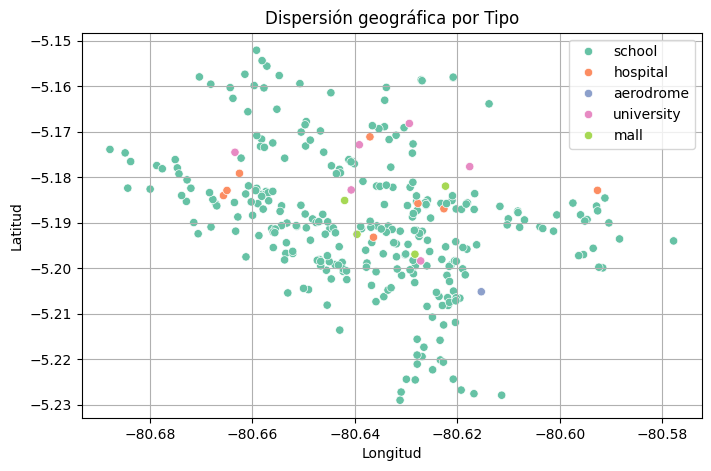

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [ ]:
# Gráfico de dispersión de latitud y longitud por tipo
plt.figure(figsize=(8, 5))
sns.scatterplot(x='Longitud', y='Latitud', hue='Tipo', data=df_coordenadas_filtradas, palette='Set2')
plt.title("Dispersión geográfica por Tipo")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.legend(loc='best')
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-24-8e928b0d9df7>:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df_coordenadas_filtradas, x='Latitud', hue='Tipo', fill=True, palette='Set2', ax=axes[0])
<ipython-input-24-8e928b0d9df7>:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df_coordenadas_filtradas, x='Longitud', hue='Tipo', fill=True, palette='Set2', ax=axes[1])


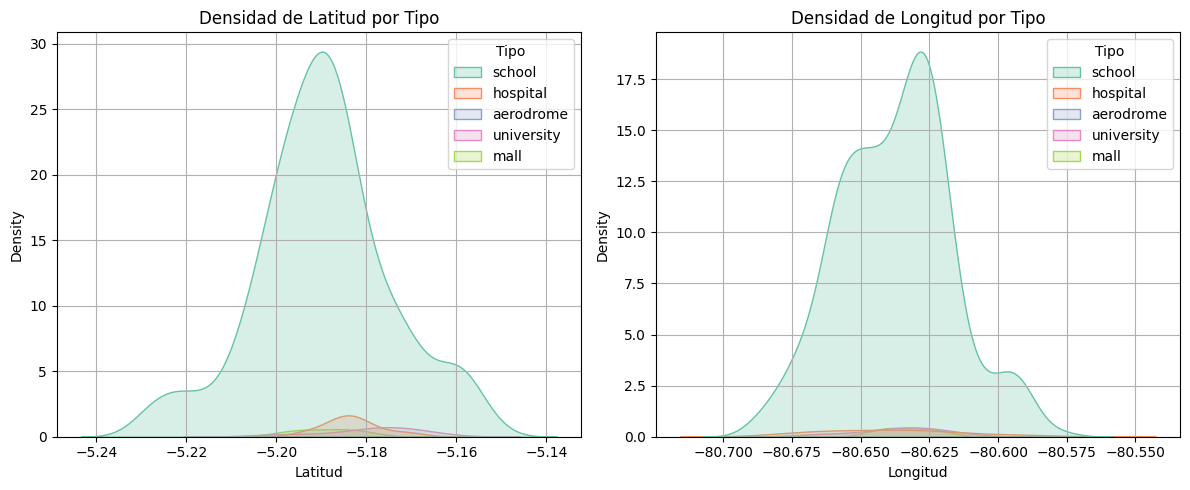

In [ ]:
# Crear subplots con 1 fila y 2 columnas
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico de densidad de latitud por tipo
sns.kdeplot(data=df_coordenadas_filtradas, x='Latitud', hue='Tipo', fill=True, palette='Set2', ax=axes[0])
axes[0].set_title("Densidad de Latitud por Tipo")
axes[0].set_xlabel("Latitud")
axes[0].grid(True)

# Gráfico de densidad de longitud por tipo
sns.kdeplot(data=df_coordenadas_filtradas, x='Longitud', hue='Tipo', fill=True, palette='Set2', ax=axes[1])
axes[1].set_title("Densidad de Longitud por Tipo")
axes[1].set_xlabel("Longitud")
axes[1].grid(True)

# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar los gráficos
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-25-00f70f84f5a5>:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df_sin_school, x='Latitud', hue='Tipo', fill=True, palette='Set2', ax=axes[0])
<ipython-input-25-00f70f84f5a5>:14: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df_sin_school, x='Longitud', hue='Tipo', fill=True, palette='Set2', ax=axes[1])


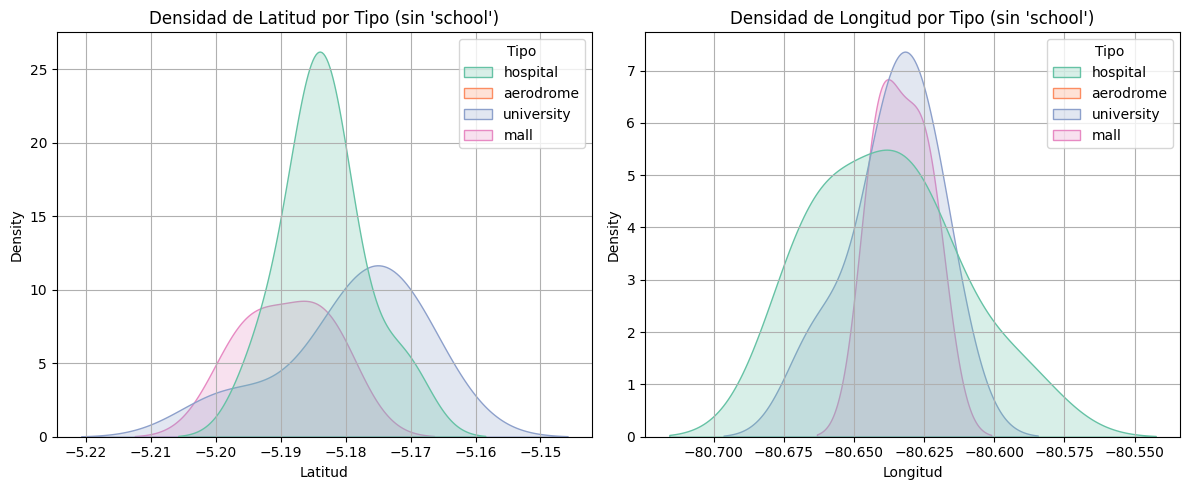

In [ ]:
# Filtrar el DataFrame para excluir el tipo 'school'
df_sin_school = df_coordenadas_filtradas[df_coordenadas_filtradas['Tipo'] != 'school']

# Crear subplots con 1 fila y 2 columnas
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico de densidad de latitud por tipo (sin 'school')
sns.kdeplot(data=df_sin_school, x='Latitud', hue='Tipo', fill=True, palette='Set2', ax=axes[0])
axes[0].set_title("Densidad de Latitud por Tipo (sin 'school')")
axes[0].set_xlabel("Latitud")
axes[0].grid(True)

# Gráfico de densidad de longitud por tipo (sin 'school')
sns.kdeplot(data=df_sin_school, x='Longitud', hue='Tipo', fill=True, palette='Set2', ax=axes[1])
axes[1].set_title("Densidad de Longitud por Tipo (sin 'school')")
axes[1].set_xlabel("Longitud")
axes[1].grid(True)

# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar los gráficos
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


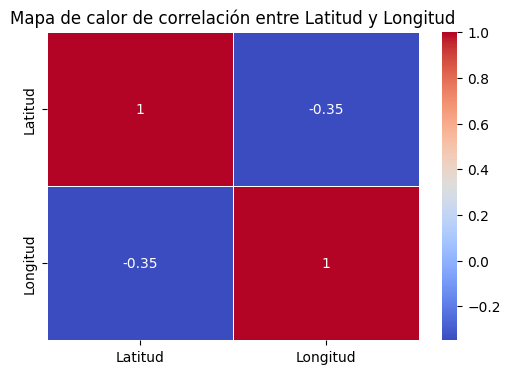

In [ ]:
# Mapa de calor de la correlación
plt.figure(figsize=(6, 4))
sns.heatmap(df_coordenadas_filtradas[['Latitud', 'Longitud']].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Mapa de calor de correlación entre Latitud y Longitud")
plt.show()

### 8. Visualización los datos ya corregidos

In [ ]:
# Crear un nuevo mapa centrado en Piura con los puntos filtrados
mapa_piura_filtrado = folium.Map(location=piura_center, zoom_start=12.4)
marker_cluster = MarkerCluster().add_to(mapa_piura_filtrado)

# Añadir los puntos filtrados al mapa
for _, row in df_coordenadas_filtradas.iterrows():
    folium.Marker(
        location=[row['Latitud'], row['Longitud']],
        popup=f"{row['Nombre']} ({row['Tipo']})",
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(marker_cluster)

# Mostrar el mapa
mapa_piura_filtrado_html = mapa_piura_filtrado._repr_html_()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Mostrar el mapa en un tamaño ajustado
display(HTML(f"""
    <div style="width: 600px; height: 400px; overflow: hidden; margin: auto;">
        {mapa_piura_filtrado_html}
    </div>
"""))

### 9. Agrupación sin prioridad

In [ ]:
# Definir un diccionario con los pesos para cada tipo de lugar
pesos_por_tipo = {
    'university': 200,
    'aerodrome': 500,
    'mall': 100,
    'hospital': 150,
    'school': 1
}

# Asignar los pesos a cada fila en función del tipo
df_coordenadas_filtradas['Peso'] = df_coordenadas_filtradas['Tipo'].apply(
    lambda x: pesos_por_tipo.get(x, 1)
)

# Extraer las columnas de latitud y longitud
coords = df_coordenadas_filtradas[['Latitud', 'Longitud']].values

# Repetir los puntos según su peso para priorizarlos
coords_ponderados = np.repeat(coords, df_coordenadas_filtradas['Peso'].values, axis=0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-30-9de3243bfadb>:13: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(K_range, inertia, 'bo-', color='blue', marker='o')
<ipython-input-30-9de3243bfadb>:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(K_range, inertia, 'bo-', color='blue', marker='o')


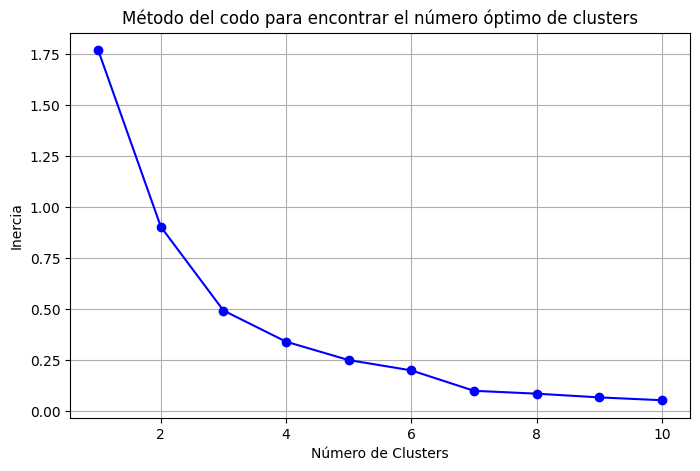

In [ ]:
# Lista para almacenar las inercia
inertia = []

# Probar con diferentes números de clusters
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(coords_ponderados)
    inertia.append(kmeans.inertia_)

# Graficar la inercia vs número de clusters
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, 'bo-', color='blue', marker='o')
plt.title('Método del codo para encontrar el número óptimo de clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

In [ ]:
# Definir el número de clusters
k = 7

# Aplicar K-Means
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(coords_ponderados)

# Obtener los centros de los clusters (ubicaciones óptimas)
centroides = kmeans.cluster_centers_

# Asignar el cluster correspondiente a cada punto original
df_coordenadas_filtradas['Cluster'] = kmeans.predict(coords)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


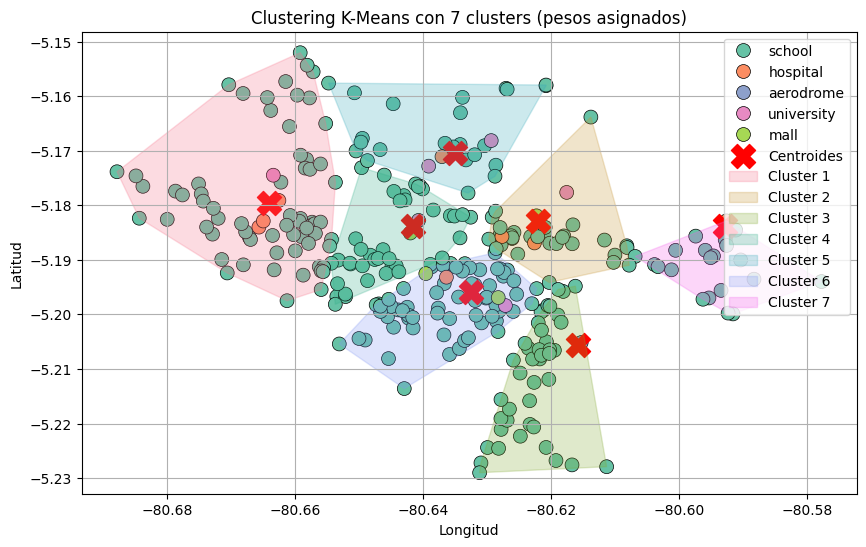

In [ ]:
# Visualización
plt.figure(figsize=(10, 6))

# Usar una paleta de colores más vibrante
vibrant_palette = sns.color_palette('husl', n_colors=k)

# Graficar los puntos con diferentes colores según el 'Tipo'
sns.scatterplot(x=df_coordenadas_filtradas['Longitud'],
                y=df_coordenadas_filtradas['Latitud'],
                hue=df_coordenadas_filtradas['Tipo'],
                palette='Set2',
                s=100,  # Tamaño de los puntos
                edgecolor='black',
                linewidth=0.5)

# Graficar los centroides
plt.scatter(centroides[:, 1], centroides[:, 0], s=300, c='red', marker='X', label='Centroides')

# Dibujar áreas sombreadas para los clusters usando ConvexHull
for i in range(k):
    cluster_points = df_coordenadas_filtradas[df_coordenadas_filtradas['Cluster'] == i]
    if len(cluster_points) >= 3:  # ConvexHull necesita al menos 3 puntos
        hull = ConvexHull(cluster_points[['Longitud', 'Latitud']].values)
        hull_vertices = hull.vertices
        plt.fill(cluster_points.iloc[hull_vertices]['Longitud'],
                 cluster_points.iloc[hull_vertices]['Latitud'],
                 alpha=0.25,
                 label=f'Cluster {i+1}',
                 color=vibrant_palette[i])

# Configuraciones finales del gráfico
plt.title(f'Clustering K-Means con {k} clusters (pesos asignados)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()